# Workshop 201 Optimized Model Serving with vLLM v1 
## Compare the LLM metrics of 1) v0 default 2) v1 3) v1 with prefix caching
![LLM_METRICS](assets/LLM_metrics.jpg)

## Install pkgs

In [1]:
!pip install -U pip
!pip install numpy transformers aiohttp pandas datasets pillow vllm matplotlib
!apt update
!apt install git -y
!git clone https://github.com/vllm-project/vllm.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 121.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.3
    Uninstalling pip-23.3:
      Successfully uninstalled pip-23.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 180.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 243.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 259.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 470.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 486.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 244.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 254.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 MB 241.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 138.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 238.9 M

## Notice: Check vLLM PORT 8100

In [36]:
# Change port Below <81xx>
PORT=8100

## Case 1 vLLM v0 Performance Benchmark

In [37]:
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:"+str(PORT)+"/v1"
client = OpenAI(
        api_key=openai_api_key,
        base_url=openai_api_base,
)
chat_response = client.chat.completions.create(
model="/models/Llama-3.1-8B-Instruct",
    messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Tell me a joke."},
        ],
    max_tokens=100,
    temperature=0.0,
)
print("server %10s got response \n\n %10s\n"%(PORT, chat_response.choices[0].message.content))

server       8101 got response 

 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."



In [38]:
!rm v0_summary.log

SRC_LOG="v0.log"
TGT_LOG="v0_summary.log"
import subprocess
log_labels = f'''
        #!/usr/bin/bash
        printf run,                     2>&1 | tee -a {TGT_LOG}
        printf prompts,                 2>&1 | tee -a {TGT_LOG}
        printf median_ttft,             2>&1 | tee -a {TGT_LOG}
        printf median_tpot,             2>&1 | tee -a {TGT_LOG}
        printf median_e2e,              2>&1 | tee -a {TGT_LOG}
        printf total_tps                2>&1 | tee -a {TGT_LOG}
        printf "\n"                     2>&1 | tee -a {TGT_LOG}
        '''
subprocess.run(log_labels, shell=True, check=True)
for concurrency in [32, 64]:
    prompts = 4 * concurrency
    isl, osl = 1024, 1024

    vllm_run = f'''
        #!/usr/bin/env bash
        python3 ./vllm/benchmarks/benchmark_serving.py \
            --model /models/Llama-3.1-8B-Instruct \
            --dataset-name random \
            --random-input-len {isl} \
            --random-output-len {osl} \
            --num-prompts {prompts} \
            --max-concurrency {concurrency} \
            --port {PORT} \
            --ignore-eos \
            --percentile-metrics ttft,tpot,e2el \
            2>&1 | tee {SRC_LOG}
        '''
    log_post_process = f'''
        #!/usr/bin/bash
        bash ./rpt_sum.sh {SRC_LOG} {TGT_LOG} v0
        '''
    subprocess.run(vllm_run, shell=True, check=True)
    subprocess.run(log_post_process, shell=True, check=True)

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
INFO 06-04 11:17:15 [__init__.py:247] No platform detected, vLLM is running on UnspecifiedPlatform
WARNING 06-04 11:17:17 [_custom_ops.py:21] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8101, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='/models/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, custom_output_len=256, custom_skip_chat_template=False, sonnet_input_len=550, sonnet_output_len=150

In [39]:
!cat v0_summary.log

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
v0,128,714.84,9.92,10859.26,6023.40
v0,256,1958.83,13.90,16114.17,8132.78


  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       714.84         9.92    10859.26    6023.40
1  v0      256      1958.83        13.90    16114.17    8132.78


<Axes: title={'center': 'total_tps (tok/sec), higher is better'}, xlabel='prompts'>

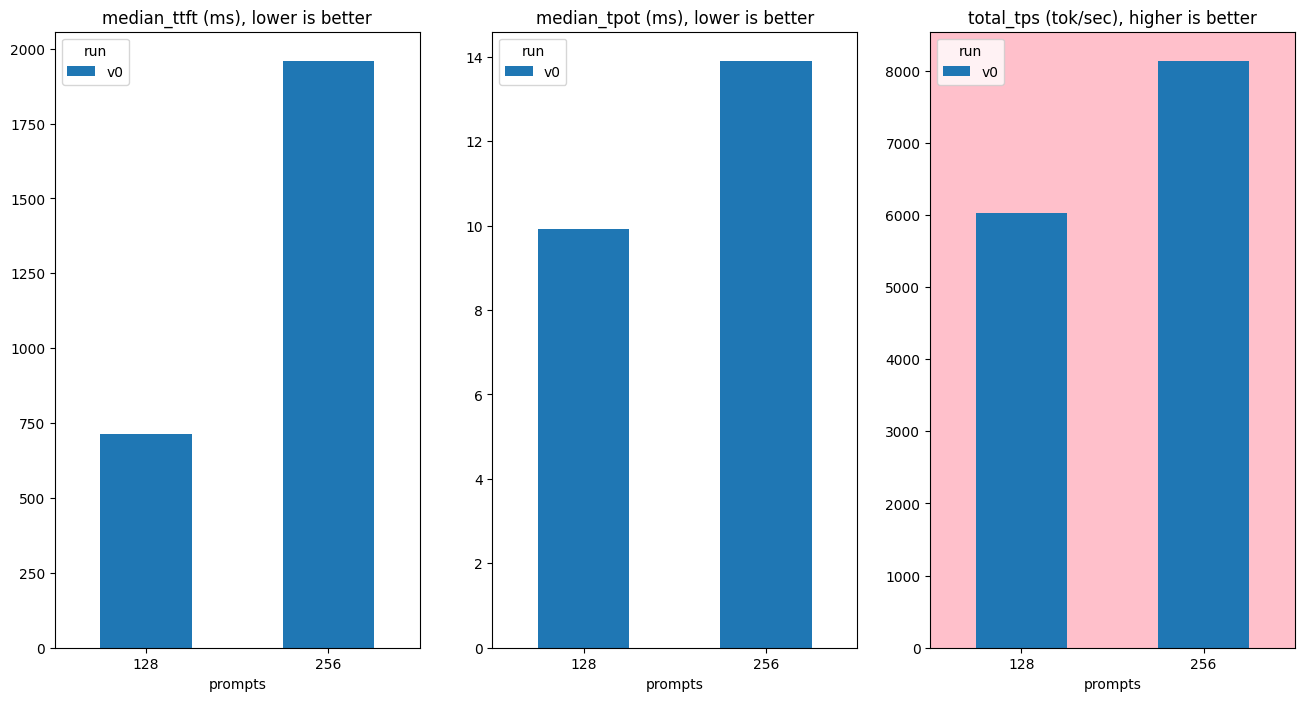

In [40]:
# Case 1) vLLM v0 Performance Benchmark Display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logs = [
    "v0_summary.log",
    ]

df_sum = pd.DataFrame()

for log in logs:
    df_log = pd.read_csv(log, sep=',')
    print(df_log)
    df_sum = pd.concat([df_sum, df_log])

fig, axes = plt.subplots(figsize=(16,8),nrows=1, ncols=3)

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_ttft')
df_sum_pivot.plot.bar(rot=0, title='median_ttft (ms), lower is better', ax=axes[0])

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_tpot')
df_sum_pivot.plot.bar(rot=0, title='median_tpot (ms), lower is better', ax=axes[1])

ax = plt.gca() 
ax.set_facecolor("pink")
df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='total_tps')
df_sum_pivot.plot.bar(rot=0, title='total_tps (tok/sec), higher is better', ax=axes[2])

## Case 2 vLLM v1 Performance Benchmark

### Now go back to the vLLM terminal and terminate the vLLM (Ctrl + C) and launch a new vLLM of Case 2) options

In [41]:
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:"+str(PORT)+"/v1"
client = OpenAI(
        api_key=openai_api_key,
        base_url=openai_api_base,
)
chat_response = client.chat.completions.create(
model="/models/Llama-3.1-8B-Instruct",
    messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Tell me a joke."},
        ],
    max_tokens=100,
    temperature=0.0,
)
print("server %10s got response \n\n %10s\n"%(PORT, chat_response.choices[0].message.content))

server       8101 got response 

 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."



In [42]:
!rm v1_summary.log

SRC_LOG="v1.log"
TGT_LOG="v1_summary.log"
import subprocess
log_labels = f'''
        #!/usr/bin/bash
        printf run,                     2>&1 | tee -a {TGT_LOG}
        printf prompts,                 2>&1 | tee -a {TGT_LOG}
        printf median_ttft,             2>&1 | tee -a {TGT_LOG}
        printf median_tpot,             2>&1 | tee -a {TGT_LOG}
        printf median_e2e,              2>&1 | tee -a {TGT_LOG}
        printf total_tps                2>&1 | tee -a {TGT_LOG}
        printf "\n"                     2>&1 | tee -a {TGT_LOG}
        '''
subprocess.run(log_labels, shell=True, check=True)
for concurrency in [32, 64]:
    prompts = 4 * concurrency
    isl, osl = 1024, 1024

    vllm_run = f'''
        #!/usr/bin/env bash
        python3 ./vllm/benchmarks/benchmark_serving.py \
            --model /models/Llama-3.1-8B-Instruct \
            --dataset-name random \
            --random-input-len {isl} \
            --random-output-len {osl} \
            --num-prompts {prompts} \
            --max-concurrency {concurrency} \
            --port {PORT} \
            --ignore-eos \
            --percentile-metrics ttft,tpot,e2el \
            2>&1 | tee {SRC_LOG}
        '''
    log_post_process = f'''
        #!/usr/bin/bash
        bash ./rpt_sum.sh {SRC_LOG} {TGT_LOG} v1
        '''
    subprocess.run(vllm_run, shell=True, check=True)
    subprocess.run(log_post_process, shell=True, check=True)

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
INFO 06-04 11:22:09 [__init__.py:247] No platform detected, vLLM is running on UnspecifiedPlatform
WARNING 06-04 11:22:11 [_custom_ops.py:21] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8101, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='/models/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, custom_output_len=256, custom_skip_chat_template=False, sonnet_input_len=550, sonnet_output_len=150

In [43]:
!cat v1_summary.log

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
v1,128,607.59,9.78,10661.55,6133.57
v1,256,875.69,13.70,14947.37,8755.59


  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       714.84         9.92    10859.26    6023.40
1  v0      256      1958.83        13.90    16114.17    8132.78
  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1      128       607.59         9.78    10661.55    6133.57
1  v1      256       875.69        13.70    14947.37    8755.59


<Axes: title={'center': 'total_tps (tok/sec), higher is better'}, xlabel='prompts'>

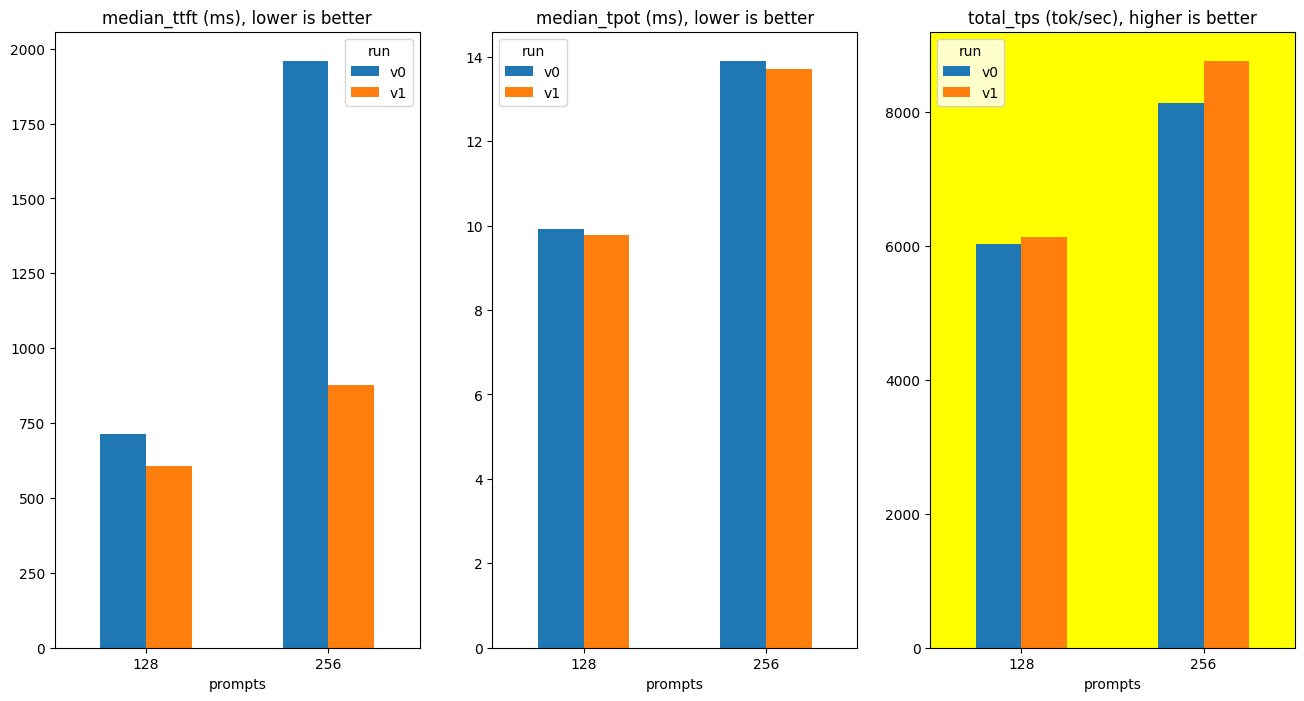

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logs = [
    "v0_summary.log",
    "v1_summary.log",
    ]

df_sum = pd.DataFrame()

for log in logs:
    df_log = pd.read_csv(log, sep=',')
    print(df_log)
    df_sum = pd.concat([df_sum, df_log])

fig, axes = plt.subplots(figsize=(16,8),nrows=1, ncols=3)

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_ttft')
df_sum_pivot.plot.bar(rot=0, title='median_ttft (ms), lower is better', ax=axes[0])

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_tpot')
df_sum_pivot.plot.bar(rot=0, title='median_tpot (ms), lower is better', ax=axes[1])

ax = plt.gca() 
ax.set_facecolor("yellow")
df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='total_tps')
df_sum_pivot.plot.bar(rot=0, title='total_tps (tok/sec), higher is better', ax=axes[2])

## Case 3 vLLM v1 + Prefix Caching Performance Benchmark

### Now go back to the vLLM terminal and terminate the vLLM (Ctrl + C) and launch a new vLLM of Case 3) options

In [45]:
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:"+str(PORT)+"/v1"
client = OpenAI(
        api_key=openai_api_key,
        base_url=openai_api_base,
)
chat_response = client.chat.completions.create(
model="/models/Llama-3.1-8B-Instruct",
    messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": "Tell me a joke."},
        ],
    max_tokens=100,
    temperature=0.0,
)
print("server %10s got response \n\n %10s\n"%(PORT, chat_response.choices[0].message.content))

server       8101 got response 

 A man walked into a library and asked the librarian, "Do you have any books on Pavlov's dogs and Schrödinger's cat?" 

The librarian replied, "It rings a bell, but I'm not sure if it's here or not."



In [46]:
!rm v1PC_summary.log
SRC_LOG="v1PC.log"
TGT_LOG="v1PC_summary.log"

import subprocess
log_labels = f'''
        #!/usr/bin/bash
        printf run,                     2>&1 | tee -a {TGT_LOG}
        printf prompts,                 2>&1 | tee -a {TGT_LOG}
        printf median_ttft,             2>&1 | tee -a {TGT_LOG}
        printf median_tpot,             2>&1 | tee -a {TGT_LOG}
        printf median_e2e,              2>&1 | tee -a {TGT_LOG}
        printf total_tps                2>&1 | tee -a {TGT_LOG}
        printf "\n"                     2>&1 | tee -a {TGT_LOG}
        '''
subprocess.run(log_labels, shell=True, check=True)
for concurrency in [32, 64]:
    prompts = 4 * concurrency
    isl, osl = 1024, 1024
        
    vllm_run_caching = f'''
        #!/usr/bin/env bash
        python3 ./vllm/benchmarks/benchmark_serving.py \
            --model /models/Llama-3.1-8B-Instruct \
            --dataset-name random \
            --random-input-len {isl} \
            --random-output-len {osl} \
            --num-prompts {prompts} \
            --max-concurrency {concurrency} \
            --port {PORT} \
            --ignore-eos \
            --percentile-metrics ttft,tpot,e2el 
        '''
    vllm_run = f'''
        #!/usr/bin/env bash
        python3 ./vllm/benchmarks/benchmark_serving.py \
            --model /models/Llama-3.1-8B-Instruct \
            --dataset-name random \
            --random-input-len {isl} \
            --random-output-len {osl} \
            --num-prompts {prompts} \
            --max-concurrency {concurrency} \
            --port {PORT} \
            --ignore-eos \
            --percentile-metrics ttft,tpot,e2el \
            2>&1 | tee {SRC_LOG}
        '''
    log_post_process = f'''
        #!/usr/bin/bash
        bash ./rpt_sum.sh {SRC_LOG} {TGT_LOG} v1_w_prefix_cache
        '''
    subprocess.run(vllm_run_caching, shell=True, check=True)
    subprocess.run(vllm_run, shell=True, check=True)
    subprocess.run(log_post_process, shell=True, check=True)

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
INFO 06-04 11:27:12 [__init__.py:247] No platform detected, vLLM is running on UnspecifiedPlatform
WARNING 06-04 11:27:13 [_custom_ops.py:21] Failed to import from vllm._C with ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')
Namespace(backend='vllm', base_url=None, host='127.0.0.1', port=8101, endpoint='/v1/completions', dataset_name='random', dataset_path=None, max_concurrency=32, model='/models/Llama-3.1-8B-Instruct', tokenizer=None, use_beam_search=False, num_prompts=128, logprobs=None, request_rate=inf, burstiness=1.0, seed=0, trust_remote_code=False, disable_tqdm=False, profile=False, save_result=False, save_detailed=False, append_result=False, metadata=None, result_dir=None, result_filename=None, ignore_eos=True, percentile_metrics='ttft,tpot,e2el', metric_percentiles='99', goodput=None, custom_output_len=256, custom_skip_chat_template=False, sonnet_input_len=550, sonnet_output_len=150

100%|██████████| 128/128 [00:42<00:00,  3.00it/s]


============ Serving Benchmark Result ============
Successful requests:                     128       
Benchmark duration (s):                  42.64     
Total input tokens:                      130944    
Total generated tokens:                  131072    
Request throughput (req/s):              3.00      
Output token throughput (tok/s):         3074.16   
Total Token throughput (tok/s):          6145.33   
---------------Time to First Token----------------
Mean TTFT (ms):                          562.59    
Median TTFT (ms):                        518.89    
P99 TTFT (ms):                           1054.03   
-----Time per Output Token (excl. 1st token)------
Mean TPOT (ms):                          9.86      
Median TPOT (ms):                        9.81      
P99 TPOT (ms):                           10.34     
----------------End-to-end Latency----------------
Mean E2EL (ms):                          10649.88  
Median E2EL (ms):                        10650.34  
P99 E2EL (ms):  

100%|██████████| 256/256 [00:55<00:00,  4.58it/s]


============ Serving Benchmark Result ============
Successful requests:                     256       
Benchmark duration (s):                  55.95     
Total input tokens:                      261888    
Total generated tokens:                  262144    
Request throughput (req/s):              4.58      
Output token throughput (tok/s):         4685.60   
Total Token throughput (tok/s):          9366.63   
---------------Time to First Token----------------
Mean TTFT (ms):                          350.35    
Median TTFT (ms):                        275.52    
P99 TTFT (ms):                           944.57    
-----Time per Output Token (excl. 1st token)------
Mean TPOT (ms):                          13.31     
Median TPOT (ms):                        13.31     
P99 TPOT (ms):                           14.48     
----------------End-to-end Latency----------------
Mean E2EL (ms):                          13967.61  
Median E2EL (ms):                        13825.90  
P99 E2EL (ms):  

In [47]:
!cat v1PC_summary.log

run,prompts,median_ttft,median_tpot,median_e2e,total_tps
v1_w_prefix_cache,128,67.42,9.47,9773.94,6689.38
v1_w_prefix_cache,256,95.96,12.68,13048.97,9988.42


  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v0      128       714.84         9.92    10859.26    6023.40
1  v0      256      1958.83        13.90    16114.17    8132.78
  run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1      128       607.59         9.78    10661.55    6133.57
1  v1      256       875.69        13.70    14947.37    8755.59
                 run  prompts  median_ttft  median_tpot  median_e2e  total_tps
0  v1_w_prefix_cache      128        67.42         9.47     9773.94    6689.38
1  v1_w_prefix_cache      256        95.96        12.68    13048.97    9988.42


<Axes: title={'center': 'total_tps (tok/sec), higher is better'}, xlabel='prompts'>

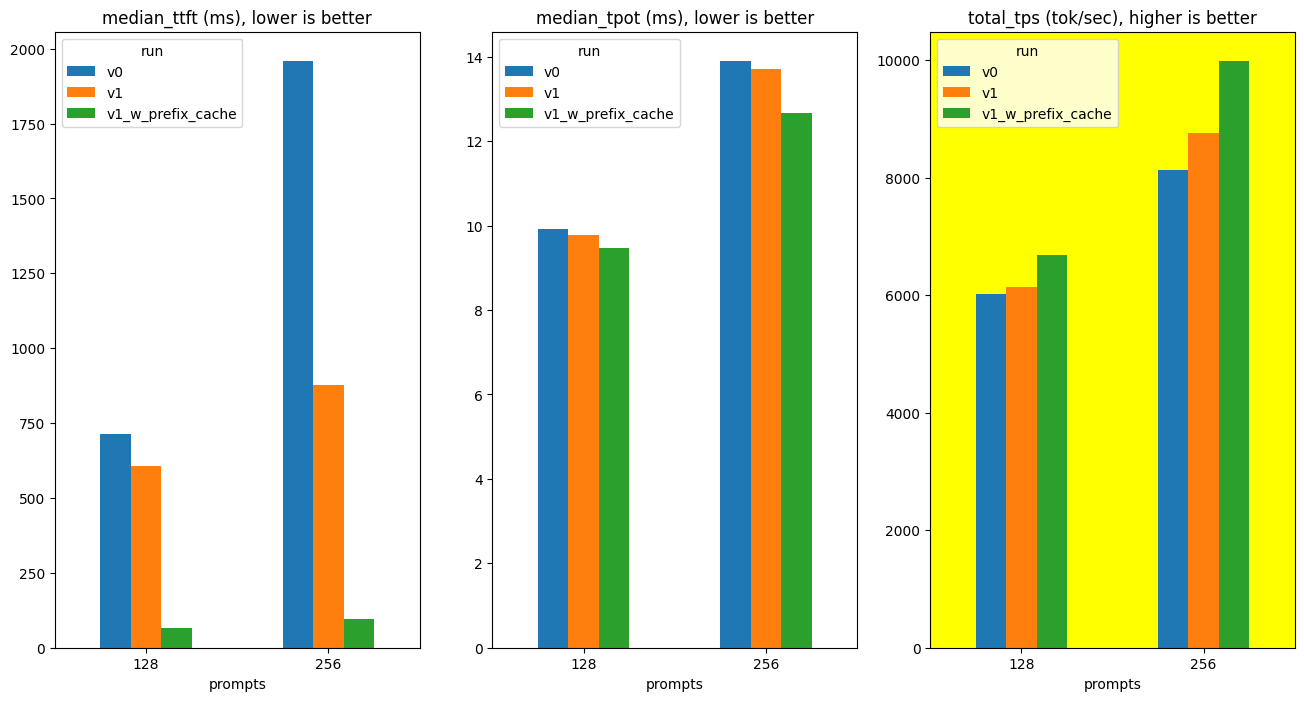

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

logs = [
    "v0_summary.log",
    "v1_summary.log",
    "v1PC_summary.log",
    ]

df_sum = pd.DataFrame()

for log in logs:
    df_log = pd.read_csv(log, sep=',')
    print(df_log)
    df_sum = pd.concat([df_sum, df_log])

fig, axes = plt.subplots(figsize=(16,8),nrows=1, ncols=3)

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_ttft')
df_sum_pivot.plot.bar(rot=0, title='median_ttft (ms), lower is better', ax=axes[0])

df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='median_tpot')
df_sum_pivot.plot.bar(rot=0, title='median_tpot (ms), lower is better', ax=axes[1])

ax = plt.gca() 
ax.set_facecolor("yellow")
df_sum_pivot=df_sum.pivot(index='prompts', columns='run', values='total_tps')
df_sum_pivot.plot.bar(rot=0, title='total_tps (tok/sec), higher is better', ax=axes[2])